In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import multiprocessing as mp
import seaborn as sns
import pickle

from cvx.stat_arb.ccp import *
from cvx.stat_arb.utils import *
from cvx.stat_arb.backtest import *

sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
# Load sector_to_asset and asset_to_sector from file
with open('../data/sector_to_asset.pkl', 'rb') as f:
    sector_to_asset = pickle.load(f)
with open('../data/asset_to_sector.pkl', 'rb') as f:
    asset_to_sector = pickle.load(f)

In [33]:
# data = pd.read_csv("../data/asset_data_2000_to_2023.csv")
# data = data.drop(["TICKER", "PERMCO"], axis=1)
# prices = pd.pivot_table(data, values='PRC', index='date', columns='PERMNO', fill_value=None)
# prices.index = pd.to_datetime(prices.index, format="%Y-%m-%d")


prices = pd.read_csv("../data/prices_500_cleaned.csv", index_col=0, parse_dates=True).dropna(axis=1, how="any")
prices.columns = prices.columns.astype(int)

# Remove Berkshire Hathaway
prices = prices.drop([540], axis=1)

# Choose sector
# assets = sector_to_asset["Finance and Insurance"]
# assets = [asset for asset in assets if asset in prices.columns]
# prices = prices[assets]

prices_train = prices.loc["2020-07-01":"2020-07-31"]
prices_val = prices.loc["2020-08-01":"2020-08-31"]
prices_test = prices.loc["2020-09-01":"2020-10-30"]

prices_train_val = pd.concat([prices_train, prices_val]) # For later use

# Static (a single time period)

In [43]:
### Get list of stat arbs
stat_arb_group = construct_stat_arbs(prices_train, K=100, P_max=25,\
     spread_max=1, M=50, solver="ECOS", seed=None, parallel=True)

100%|██████████| 100/100 [00:02<00:00, 41.45it/s]


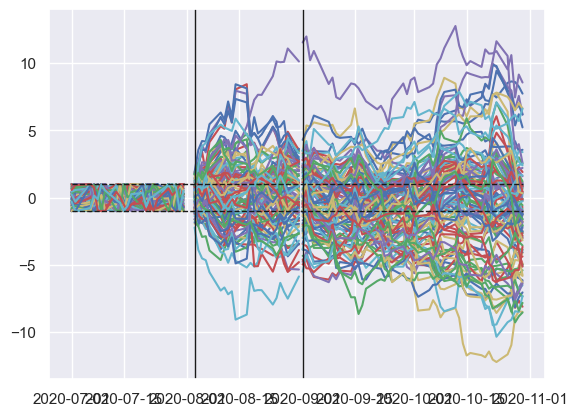

In [35]:
### Plot stat arb group
plot_all_portfolios(stat_arb_group.stat_arbs, prices_train, prices_val, prices_test)

# Trading backtest

### Using the Portfolio class

In [44]:
stat_arbs_validated = stat_arb_group.validate(prices_val,
         prices_train_val, 1, 1)

portfolio = stat_arbs_validated.construct_portfolio(prices_test, 1)

m_p = Metrics(portfolio.profit)
print("profit: ", np.round(m_p.total_profit,2))
print("SR: ", np.round(m_p.sr_profit,2))

profit:  1.46
SR:  5.07


In [45]:
len(stat_arbs_validated.stat_arbs)

2

In [16]:
m_p.total_profit

-2.2350204885067138

In [22]:
len(stat_arbs_validated.stat_arbs)

7

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


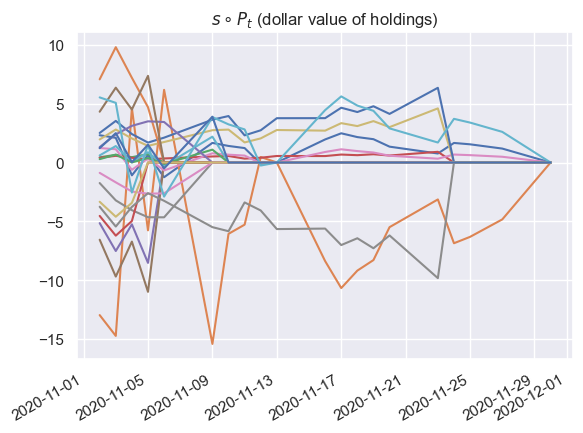

In [15]:
### Visualize portfolio holdings
holdings = portfolio.stocks * portfolio.prices
plt.plot(holdings.index, holdings);
plt.legend(holdings.columns, bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title(r"$s\circ P_t$ (dollar value of holdings)");
plt.gcf().autofmt_xdate()
plt.gca().legend().remove();

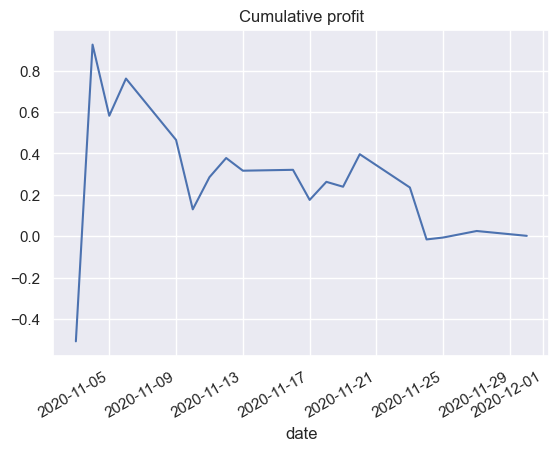

In [16]:
m_p.daily_profit.cumsum().plot(); plt.title("Cumulative profit");

Fraction of profitable stat arbs:  0.5714285714285714
Average profit of profitable stat arbs:  0.4057450478736443
Average loss of unprofitable stat arbs:  -0.28309865358137015


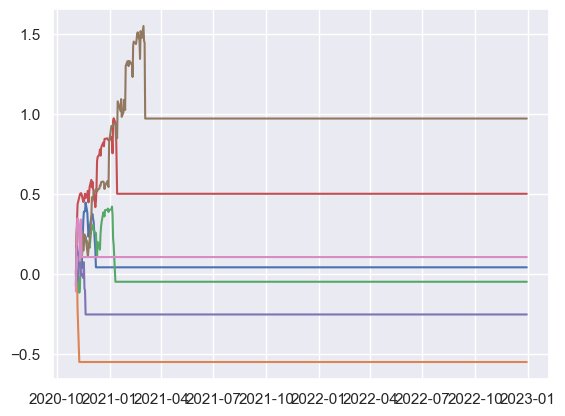

In [181]:
profitable = 0
unprofitable = 0
wins = []
losses = []
for stat_arb in stat_arbs_validated.stat_arbs:
    m = stat_arb.metrics(prices_test)
    if m is not None:
        plt.plot(m.daily_profit.cumsum())
        if m.total_profit > 0:
            profitable += 1
            wins.append(m.total_profit)
        else:
            unprofitable += 1
            losses.append(m.total_profit)


print("Fraction of profitable stat arbs: ", profitable / (profitable + unprofitable))
print("Average profit of profitable stat arbs: ", np.mean(wins))
print("Average loss of unprofitable stat arbs: ", np.mean(losses))

#### Using the StatArbGroup class

In [17]:
stat_arb_group = StatArbGroup(stat_arbs_validated.stat_arbs)

In [20]:
m_sg   = stat_arb_group.metrics(prices_test, cutoff=1.05)
print("profit: ", np.round(m_sg.total_profit, 2))
print("SR: ", np.round(m_sg.sr_profit,2))

profit:  6.26
SR:  4.1


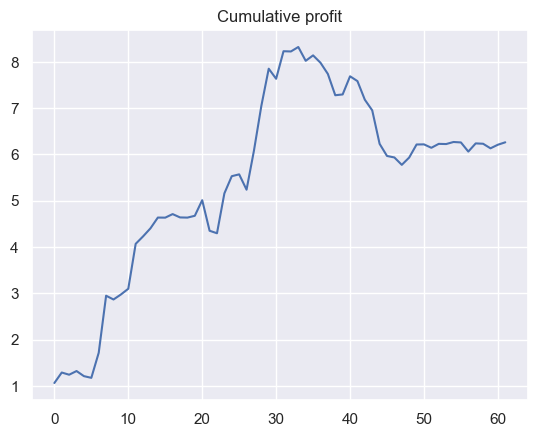

In [21]:
plt.plot(m_sg.daily_profit.cumsum().values); plt.title("Cumulative profit");